<a href="https://colab.research.google.com/github/gbirhanu/DeepLearning/blob/main/TweetSentimentExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Sentiment extraction on colab
Here is step by step how to download Kaggle data set to Colab

In [2]:
!pip install transformers

     |████████████████████████████████| 1.5MB 5.6MB/s 
     |████████████████████████████████| 2.9MB 18.5MB/s 
     |████████████████████████████████| 890kB 36.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=c2ab6ed2502aba5ce09ae91737c349609469cac15613c1ef07ddbbc4a3ac5c42
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

## Install Kaggle
For detail explanation please visit [here](https://www.kaggle.com/general/74235)

In [4]:
!pip install -q kaggle

## uplaod kaggle.json to colab

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"gbirhanu","key":"baa6625db2cc0d4d1526f576a88d7808"}'}

In [6]:
! mkdir ~/.kaggle

In [8]:
!cp /content/kaggle.json /root/.kaggle/

In [9]:
! chmod 600 /root/.kaggle/

In [10]:
!ls /root/.kaggle/

kaggle.json


# New Section

In [11]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import os
import warnings
import random
import torch 
from torch import nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
import tokenizers
from transformers import RobertaModel, RobertaConfig

warnings.filterwarnings('ignore')

In [12]:
! kaggle datasets list

ref                                                           title                                                size  lastUpdated          downloadCount  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
utkarshxy/who-worldhealth-statistics-2020-complete            World Health Statistics 2020|Complete|Geo-Analysis    1MB  2021-01-10 18:25:49           2672  
gpreda/pfizer-vaccine-tweets                                  Pfizer Vaccine Tweets                               541KB  2021-01-13 08:04:33           1689  
arashnic/covid19-case-surveillance-public-use-dataset         Covid-19 Case Surveillance Public Use Dataset        46MB  2020-12-21 02:24:21           1373  
ashkhagan/women-representation-in-city-property-sanfrancisco  Women Representation in City Property SanFrancisco    3KB  2020-12-13 05:18:14            410  
google/android-smartphones-high-accuracy-datasets   

In [13]:
! kaggle competitions download -c tweet-sentiment-extraction

  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 86.8MB/s]
  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 100MB/s]
  0% 0.00/41.4k [00:00<?, ?B/s]
100% 41.4k/41.4k [00:00<00:00, 35.4MB/s]


In [14]:
! mkdir train

In [15]:
! unzip train.csv.zip -d train

Archive:  train.csv.zip
  inflating: train/train.csv         


In [16]:
!ls

kaggle.json  sample_data  sample_submission.csv  test.csv  train  train.csv.zip


## Tweet sentiment extraction using ROBERTA Transformer

## import necessary files and dataset

In [29]:
! pip install transformers

In [30]:
import numpy as np
import pandas as pd
import os
import warnings
import random
import torch 
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
import tokenizers
from transformers import RobertaModel, RobertaConfig,AutoTokenizer

warnings.filterwarnings('ignore')

In [19]:
!mv /content/test.csv /content/train/

In [20]:
!mv /content/sample_submission.csv /content/train/

In [21]:
train = pd.read_csv('/content/train/train.csv')
test = pd.read_csv('/content/train/test.csv')
ss = pd.read_csv('/content/train/sample_submission.csv')

In [22]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


## Tweet sentiment extraction

This problem is asked by kaggle on kaggle [Compitition](https://www.kaggle.com/c/tweet-sentiment-extraction). The idea is this. Kaggle take the data set from Appen who use diffrent users to extract a word or phrase contribute to sentiment. for example, in the tweet which says "I really really like the song Love Story by Taylor Swift" the sentiment is positive and the contributing word for this sentiment is the word "LIke". So the problem is to select this contributing word or phrases in the given tweet. As described by many who have participated in the compitition what was asked here is mimicking the human labelers, which may not be consistent when they select the contributing text.

## Framing the problem

In order to solve the problem, first we have to frame the problem in to one of the NLP model. for example the problem can be framed as :


*   Named Entity Recognition
*   Text Summarization or
*   Question answering 

Upon Reading diffrent litirature I have decided to consider the problem as Question answering 

## Which Model to Use

Definately I am going to use transformers, due to that they are state of the art of langauge modelling. But which one? well we are going to implement all which have developed for QA problem. Among them:
* RoBERTA 
* DistilBert
* XLM
* XLM-RoBERTa
* Funnel Transformer
* Longformer
* XLM-ProphetNet

Lets first do some EDA


## EDA




Our data have the following shape

In [23]:
print(train.shape), print(test.shape)

(27481, 4)
(3534, 3)


(None, None)

Here the train data have 4 columns where as the test have only 3. train data have selected_text which contribute to sentiment, where test data does not have that we are going to generate that after we traind our model.

In [24]:
train.columns

Index(['textID', 'text', 'selected_text', 'sentiment'], dtype='object')

In [25]:
test.columns

Index(['textID', 'text', 'sentiment'], dtype='object')

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [27]:
X_train = train

In [28]:
X_train.dropna()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [29]:
X_train.dropna(inplace=True)

In [30]:
X_train.shape

(27480, 4)

We removed columns with null value

Let's study the behavour of the data with their repective sentiment.

In [31]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


Let's visualize it using seeborn graph

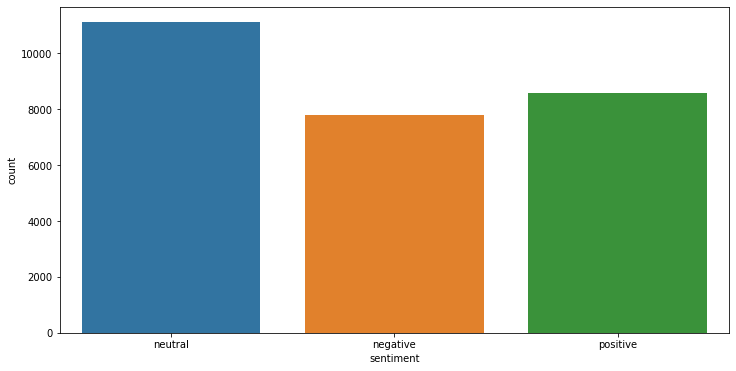

In [32]:
plt.figure(figsize=(12,6))
sb.countplot(x='sentiment',data=train)

As depicted in the above graph most of the tweets are neutral. Now lets see the relationship of text and selected_text for each sentiment. we are going to see  their similarity first.

For similarity we are going to use Jaccard similarity wich is also called intercetion over union.
for example if we have string A and String B their Jaccard similarity will be given as follows:

   $ $Jaccard_similarity = $A \cap B \over (A \cup B) $

Let's define helper function for getting this jaccard similarity



In [33]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [34]:
results_jaccard=[]

for ind,row in X_train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = jaccard(sentence1,sentence2)
    results_jaccard.append([sentence1,sentence2,jaccard_score])

In [35]:
jaccard = pd.DataFrame(results_jaccard,columns=["text","selected_text","jaccard_score"])
X_train = X_train.merge(jaccard,how='outer')

In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27479
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   textID         27480 non-null  object 
 1   text           27480 non-null  object 
 2   selected_text  27480 non-null  object 
 3   sentiment      27480 non-null  object 
 4   jaccard_score  27480 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.3+ MB


In [37]:
X_train.head()

,textID,text,selected_text,sentiment,jaccard_score
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286


In [38]:
X_train.tail()

,textID,text,selected_text,sentiment,jaccard_score
27475,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,0.058824
27476,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,0.083333
27477,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,0.272727
27478,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,1.000000
27479,6f7127d9d7,All this flirting going on - The ATG smiles...,All this flirting going on - The ATG smiles. Y...,neutral,0.833333


## Jaccard Similarity for each sentiment
let see the jaccard similarity for each sentiment

In [39]:
X_train.groupby('sentiment').mean()['jaccard_score']

sentiment
negative    0.338613
neutral     0.976445
positive    0.314372
Name: jaccard_score, dtype: float64

This indicates that for neutral text the selected_text and texts are almost similar (97%) similarity. that means if we just return text for selected text we will have 97 % accuracy. Intuitevly that make sense, due to that neutral tweets does not have sentiment, so the annotators does not select any text for such tweets. Selected_texts are word or phrases contribute for sentiments. 

## Data Sets Preparation
This much EDA may be enough for now. let's go to build the model. in order to build the model we have to prepare dataset which will be easly manipulated by our model.

The first model we are going to try will be RoBERTA model.
let start by importing it.

In [40]:
from transformers import RobertaTokenizer, RobertaModel, RobertaConfig
import torch.nn as nn 

In [41]:
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}

In [42]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [43]:
tokenizer("hello world")['input_ids']


[0, 42891, 232, 2]

In [44]:
tokenizer.encode("Hello world")

[0, 31414, 232, 2]

In [45]:
tokenizer("positive")['input_ids']

[0, 22173, 2]

In [46]:
MAX_LEN = 96
ct = X_train.shape[0]
ct

27480

Unknown option: -r
usage: python3 [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.


In [4]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed = 42
seed_everything(seed)

In [49]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, df, max_len=96):
        self.df = df
        self.max_len = max_len
        self.labeled = 'selected_text' in df
        self.tokenizer = tokenizers.ByteLevelBPETokenizer(
            vocab='/content/roberta-base/vocab.json', 
            merges='/content/roberta-base/merges.txt', 
            lowercase=True,
            add_prefix_space=True)

    def __getitem__(self, index):
        data = {}
        row = self.df.iloc[index]
        
        ids, masks, tweet, offsets = self.get_input_data(row)
        data['ids'] = ids
        data['masks'] = masks
        data['tweet'] = tweet
        data['offsets'] = offsets
        
        if self.labeled:
            start_idx, end_idx = self.get_target_idx(row, tweet, offsets)
            data['start_idx'] = start_idx
            data['end_idx'] = end_idx
        
        return data

    def __len__(self):
        return len(self.df)
    
    def get_input_data(self, row):
        tweet = " " + " ".join(row.text.lower().split())
        encoding = self.tokenizer.encode(tweet)
        sentiment_id = self.tokenizer.encode(row.sentiment).ids
        ids = [0] + sentiment_id + [2, 2] + encoding.ids + [2]
        offsets = [(0, 0)] * 4 + encoding.offsets + [(0, 0)]
                
        pad_len = self.max_len - len(ids)
        if pad_len > 0:
            ids += [1] * pad_len
            offsets += [(0, 0)] * pad_len
        
        ids = torch.tensor(ids)
        masks = torch.where(ids != 1, torch.tensor(1), torch.tensor(0))
        offsets = torch.tensor(offsets)
        
        return ids, masks, tweet, offsets
        
    def get_target_idx(self, row, tweet, offsets):
        selected_text = " " +  " ".join(row.selected_text.lower().split())

        len_st = len(selected_text) - 1
        idx0 = None
        idx1 = None

        for ind in (i for i, e in enumerate(tweet) if e == selected_text[1]):
            if " " + tweet[ind: ind+len_st] == selected_text:
                idx0 = ind
                idx1 = ind + len_st - 1
                break

        char_targets = [0] * len(tweet)
        if idx0 != None and idx1 != None:
            for ct in range(idx0, idx1 + 1):
                char_targets[ct] = 1

        target_idx = []
        for j, (offset1, offset2) in enumerate(offsets):
            if sum(char_targets[offset1: offset2]) > 0:
                target_idx.append(j)

        start_idx = target_idx[0]
        end_idx = target_idx[-1]
        
        return start_idx, end_idx
        
def get_train_val_loaders(df, train_idx, val_idx, batch_size=8):
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    train_loader = torch.utils.data.DataLoader(
        TweetDataset(train_df), 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=2,
        drop_last=True)

    val_loader = torch.utils.data.DataLoader(
        TweetDataset(val_df), 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2)

    dataloaders_dict = {"train": train_loader, "val": val_loader}

    return dataloaders_dict

def get_test_loader(df, batch_size=32):
    loader = torch.utils.data.DataLoader(
        TweetDataset(df), 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=2)    
    return loader

In [6]:
# def DatasetPreparation(X):
#   ct = X.shape[0]
#   input_ids = np.ones((ct,MAX_LEN),dtype='int32')
#   attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
#   token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')
#   start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
#   end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
#   for k in range(ct):
    
#     # FIND OVERLAP
#     text1 = " "+" ".join(X_train.loc[k,'text'].split())
#     text2 = " ".join(X_train.loc[k,'selected_text'].split())
#     idx = text1.find(text2)
#     chars = np.zeros((len(text1)))
#     chars[idx:idx+len(text2)]=1
#     if text1[idx-1]==' ': chars[idx-1] = 1 
#     enc = tokenizer.encode(text1) 
        
#     # ID_OFFSETS
#     offsets = []; idx=0
#     for t in enc:#.ids:
#         w = tokenizer.decode([t])
#         offsets.append((idx,idx+len(w)))
#         idx += len(w)    
#     # START END TOKENS
#     toks = []
#     for i,(a,b) in enumerate(offsets):
#         sm = np.sum(chars[a:b])
#         if sm>0: toks.append(i) 
        
#     s_tok = sentiment_id[X_train.loc[k,'sentiment']]
#     input_ids[k,:len(enc)+5] = [0] + enc + [2,2] + [s_tok] + [2]
#     attention_mask[k,:len(enc)+5] = 1
#     if len(toks)>0:
#         start_tokens[k,toks[0]+1] = 1
#         end_tokens[k,toks[-1]+1] = 1
#     return start_tokens, 



In [7]:
#tokenizer.decode(input_ids[0,:])

In [9]:
# ct = test.shape[0]
# ct

In [ ]:
# ct = test.shape[0]
# input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
# attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
# token_type_ids_t = np.zeros((ct,MAX_LEN),dtype='int32')

# for k in range(test.shape[0]):
        
#     # INPUT_IDS
#     text1 = " "+" ".join(test.loc[k,'text'].split())
#     enc = tokenizer.encode(text1)                
#     s_tok = sentiment_id[test.loc[k,'sentiment']]
#     input_ids_t[k,:len(enc)+5] = [0] + enc + [2,2] + [s_tok] + [2]
#     attention_mask_t[k,:len(enc)+5] = 1
# input_ids_t

In [ ]:
# def build_model():
#     ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
#     att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
#     tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

#     #config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
#     #bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
#     bert_model = TFRobertaModel.from_pretrained('roberta-base')
#     x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
#     x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
#     x1 = tf.keras.layers.Conv1D(1,1)(x1)
#     x1 = tf.keras.layers.Flatten()(x1)
#     x1 = tf.keras.layers.Activation('softmax')(x1)
    
#     x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
#     x2 = tf.keras.layers.Conv1D(1,1)(x2)
#     x2 = tf.keras.layers.Flatten()(x2)
#     x2 = tf.keras.layers.Activation('softmax')(x2)

#     model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
#     optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
#     model.compile(loss='categorical_crossentropy', optimizer=optimizer)

#     return model

In [ ]:
!mkdir roberta-base

In [ ]:
from google.colab import files
files.upload()

In [50]:
class TweetModel(nn.Module):
    def __init__(self):
        super(TweetModel, self).__init__()
        
        config = RobertaConfig.from_pretrained(
            '/content/roberta-base/config.json', output_hidden_states=True)    
        self.roberta = RobertaModel.from_pretrained(
            '/content/pytorch_model.bin', config=config)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(config.hidden_size, 2)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        _, _, hs = self.roberta(input_ids, attention_mask)
         
        x = torch.stack([hs[-1], hs[-2], hs[-3], hs[-4]])
        x = torch.mean(x, 0)
        x = self.dropout(x)
        x = self.fc(x)
        start_logits, end_logits = x.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)
                
        return start_logits, end_logits

In [51]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    ce_loss = nn.CrossEntropyLoss()
    start_loss = ce_loss(start_logits, start_positions)
    end_loss = ce_loss(end_logits, end_positions)    
    total_loss = start_loss + end_loss
    return total_loss

In [52]:
def get_selected_text(text, start_idx, end_idx, offsets):
    selected_text = ""
    for ix in range(start_idx, end_idx + 1):
        selected_text += text[offsets[ix][0]: offsets[ix][1]]
        if (ix + 1) < len(offsets) and offsets[ix][1] < offsets[ix + 1][0]:
            selected_text += " "
    return selected_text

def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

def compute_jaccard_score(text, start_idx, end_idx, start_logits, end_logits, offsets):
    start_pred = np.argmax(start_logits)
    end_pred = np.argmax(end_logits)
    if start_pred > end_pred:
        pred = text
    else:
        pred = get_selected_text(text, start_pred, end_pred, offsets)
        
    true = get_selected_text(text, start_idx, end_idx, offsets)
    
    return jaccard(true, pred)

In [53]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, filename):
    model.cuda()

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_jaccard = 0.0
            
            for data in (dataloaders_dict[phase]):
                ids = data['ids'].cuda()
                masks = data['masks'].cuda()
                tweet = data['tweet']
                offsets = data['offsets'].numpy()
                start_idx = data['start_idx'].cuda()
                end_idx = data['end_idx'].cuda()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    start_logits, end_logits = model(ids, masks)

                    loss = criterion(start_logits, end_logits, start_idx, end_idx)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * len(ids)
                    
                    start_idx = start_idx.cpu().detach().numpy()
                    end_idx = end_idx.cpu().detach().numpy()
                    start_logits = torch.softmax(start_logits, dim=1).cpu().detach().numpy()
                    end_logits = torch.softmax(end_logits, dim=1).cpu().detach().numpy()
                    
                    for i in range(len(ids)):                        
                        jaccard_score = compute_jaccard_score(
                            tweet[i],
                            start_idx[i],
                            end_idx[i],
                            start_logits[i], 
                            end_logits[i], 
                            offsets[i])
                        epoch_jaccard += jaccard_score
                    
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_jaccard = epoch_jaccard / len(dataloaders_dict[phase].dataset)
            
            print('Epoch {}/{} | {:^5} | Loss: {:.4f} | Jaccard: {:.4f}'.format(
                epoch + 1, num_epochs, phase, epoch_loss, epoch_jaccard))
    
    torch.save(model.state_dict(), filename)

In [54]:
num_epochs = 3
batch_size = 32
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [55]:
%%time
train_df = pd.read_csv('/content/train/train.csv')
train_df['text'] = train_df['text'].astype(str)
train_df['selected_text'] = train_df['selected_text'].astype(str)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df.sentiment), start=1): 
    print(f'Fold: {fold}')

    model = TweetModel()
    optimizer = optim.AdamW(model.parameters(), lr=3e-5, betas=(0.9, 0.999))
    criterion = loss_fn    
    dataloaders_dict = get_train_val_loaders(train_df, train_idx, val_idx, batch_size)

    train_model(
        model, 
        dataloaders_dict,
        criterion, 
        optimizer, 
        num_epochs,
        f'roberta_fold{fold}.pth')

Fold: 1


RuntimeError: ignored

In [18]:
%%time
test_df = pd.read_csv('/content/train/test.csv')
test_df['text'] = test_df['text'].astype(str)
test_loader = get_test_loader(test_df)
predictions = []
models = []
for fold in range(skf.n_splits):
    model = TweetModel()
    model.cuda()
    model.load_state_dict(torch.load(f'roberta_fold{fold+1}.pth'))
    model.eval()
    models.append(model)

for data in test_loader:
    ids = data['ids'].cuda()
    masks = data['masks'].cuda()
    tweet = data['tweet']
    offsets = data['offsets'].numpy()

    start_logits = []
    end_logits = []
    for model in models:
        with torch.no_grad():
            output = model(ids, masks)
            start_logits.append(torch.softmax(output[0], dim=1).cpu().detach().numpy())
            end_logits.append(torch.softmax(output[1], dim=1).cpu().detach().numpy())

    start_logits = np.mean(start_logits, axis=0)
    end_logits = np.mean(end_logits, axis=0)
    for i in range(len(ids)):    
        start_pred = np.argmax(start_logits[i])
        end_pred = np.argmax(end_logits[i])
        if start_pred > end_pred:
            pred = tweet[i]
        else:
            pred = get_selected_text(tweet[i], start_pred, end_pred, offsets[i])
        predictions.append(pred)

TypeError: ignored

In [ ]:
sub_df = pd.read_csv('/content/train/sample_submission.csv')
sub_df['selected_text'] = predictions
sub_df['selected_text'] = sub_df['selected_text'].apply(lambda x: x.replace('!!!!', '!') if len(x.split())==1 else x)
sub_df['selected_text'] = sub_df['selected_text'].apply(lambda x: x.replace('..', '.') if len(x.split())==1 else x)
sub_df['selected_text'] = sub_df['selected_text'].apply(lambda x: x.replace('...', '.') if len(x.split())==1 else x)
sub_df.to_csv('submission.csv', index=False)
sub_df.head()